# Second task
In this second task the goal is to identify the russet or at least some part of it in a daset of apple's images in order to correctly classify the two fruits. 

## Step 1 - Binarization

## Step 2 - Segmentation

## Step 3 - Smoothing

## Step 4 - Find defect colour with samples

## Step 5 - Compute the Mahalanobis distance

## Step 6 - Defects Identification

# Code

In [1]:
import cv2
import numpy as np
from tools import array_of_images, get_threshold, fill_element, show_images, draw_fruit_outline, upload_samples, mahalanobis_sample, get_component, draw_defect
from scipy.spatial.distance import cdist

Malahanobis

In [3]:
image_path = "./Second_task/images"
gray_images, color_images = array_of_images(image_path)
sample_path = "./Second_task/images/defects"
samples = upload_samples(sample_path)

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1711055189356/work/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


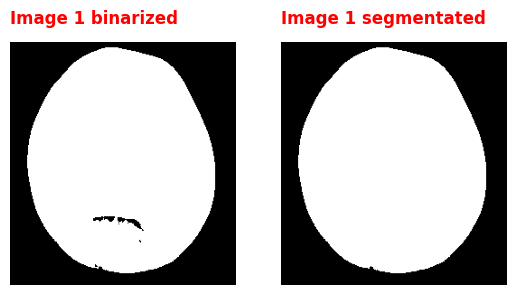

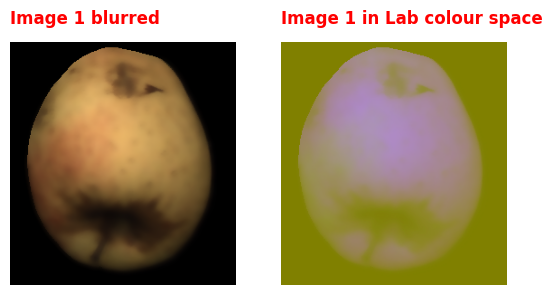

In [9]:
image_count = 1
for i in range(len(gray_images)):
    gray_image = gray_images[i]
    color_image = color_images[i]

    # Convert image to grayscale
    gray = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)

    #STEP 1 - BINARIZATION
    # Calculate the adaptive threshold as  median / 2' 
    median = get_threshold(gray)

    # Binarize the image to separate foreground and background
    threshold, binarized = cv2.threshold(gray, median, 255, cv2.THRESH_BINARY)

    #Step 2 - SEGMENTATION
    # Find the fruit in the image as it is the biggest connencted component
    filled_image = fill_element(binarized)

    show_images("Image " + str(image_count) + " binarized", "Image " + str(image_count) + " segmentated", binarized, filled_image)


    # Erode one time to remove dark contour
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(filled_image, kernel, iterations=1)

    #Step 3 - SMOOTHING
    # Get grayscale fruit from filled mask
    gs = cv2.bitwise_and(color_image, color_image, mask=filled_image)
    #Blurred image with the bilateral filter, that is an edge-preserving filter
    blurred_image = cv2.bilateralFilter(gs, 11, 100, 75)

    fruit = cv2.bitwise_and(blurred_image, blurred_image, mask=eroded)
    # Convert isolated fruit to Lab color space to preserve perceptual meaning
    fruit_lab = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2LAB)

    show_images("Image " + str(image_count) + " blurred", "Image " + str(image_count) + " in Lab colour space", blurred_image, fruit_lab)

    #Step 4 - FIND DEFECT COLOUR WITH SAMPLES
    # Create data structures to store total covariance and mean of samples
    covariance_tot = np.zeros((2, 2), dtype="float64")
    mean_tot = np.zeros((1, 2), dtype="float64")
    
    for s in samples:
        s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, 1:3]
        s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
        cov, mean = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
        covariance_tot = np.add(covariance_tot, cov)
        mean_tot = np.add(mean_tot, mean)

    # Compute the mean of the means of all the samples to find the reference color
    russet_sample = mean_tot / len(samples)


    #Step 5 - COMPUTE THE MAHALANOBIS DISTANCE
    # Compute the inverse of the covariance matrix (needed to measure Mahalanobis distance)
    inv_cov = cv2.invert(covariance_tot, cv2.DECOMP_SVD)[1]

    russet_component = np.zeros_like(binarized)

    # Compute pixel-wise Mahalanobis distance between fruit and reference color
    for r in range(fruit_lab.shape[0]):
        for c in range(fruit_lab.shape[1]):
            if filled_image[r][c]:
                p = np.array(fruit_lab[r][c])[1:3].reshape(1, 2)
                # Mahalanobis distance
                dist = cdist(p, russet_sample, 'mahalanobis', VI=inv_cov)

                # Checking if the distance is small, than p is part of the russet
                if dist < 1.5:
                    # Store russet's pixel location
                    russet_component[r][c] = 255

    #Step 6 - DEFECTS IDENTIFICATION 
    # Perform a connected components labeling of the russet
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(russet_component, 4)
    original = color_image.copy()

    # Outline the fruit using the binary mask
    draw_fruit_outline(original, filled_image, 1)

    #Identification of the defects by isolating them when iterating over the detected components
    defects_counter = 0
    for j in range(1, retval):
        component = get_component(labels, j)
        defects_counter += draw_defect(original, component, 2, 1.1, 35, float("inf"), 5)

    russet = cv2.bitwise_and(fruit, fruit, mask=russet_component)

    show_images("Russet", "Original with russet", russet, original)

    #RECAP
    print("In the image 0" + str(image_count) + " the system detected " + str(defects_counter) + " defect(s)")
    image_count += 1
